In [1]:
#load all necessary packages
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')

import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
import edward2 as ed
tfd = tfp.distributions
tf.disable_eager_execution()

sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(111)
tf.set_random_seed(111)

# A. Redwine data Overview

we have 11 columns for features, 1 column for target label -- quality of the wine. Even the target quality is integer, we will still treat this problem as a regression problem and train MCMC simulation to estimate the quality given a record.

In [2]:
data = pd.read_csv("winequality-red.csv",sep=';')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


# B. Explore the dataset

### b1. target label -- quality
As shown in the chart, quality is not distribution evenly, which will create more chanllenge to traditional machine learning frameworks. Here we will use Bayesian probability neural network to get the Probability Density Function of each target quality.

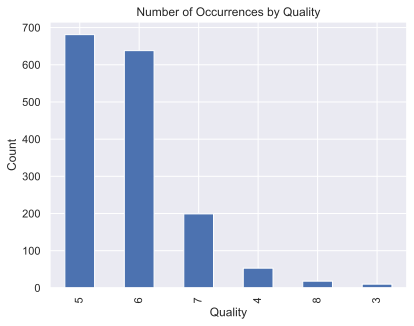

In [3]:
#target label - quality explore
data['quality'].value_counts().plot(kind = 'bar')
plt.title('Number of Occurrences by Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

### b2. features
we can tell that most of the features are distributed nicely into Gaussian Form, so we can use Linear regression structure to solve our problem after we normalized our dataset.

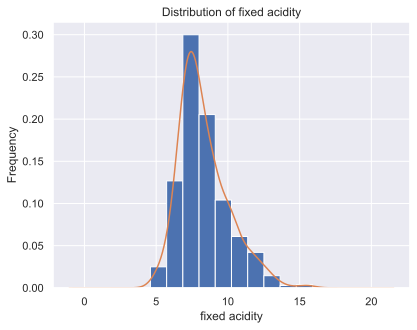

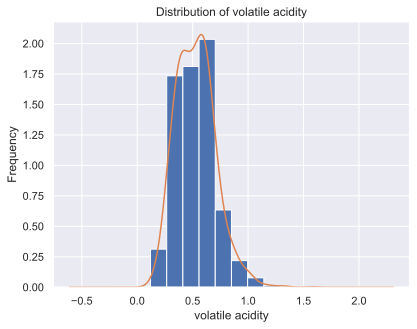

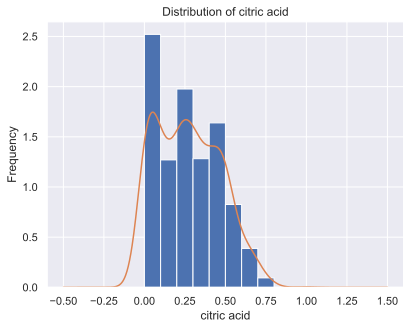

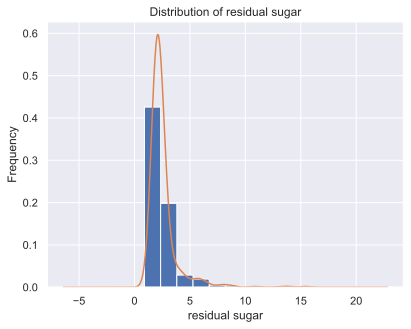

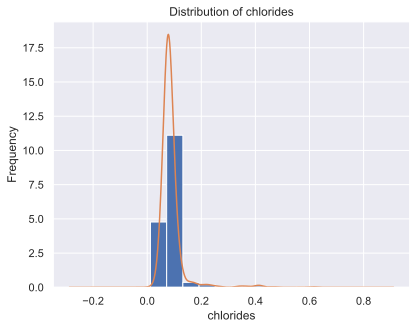

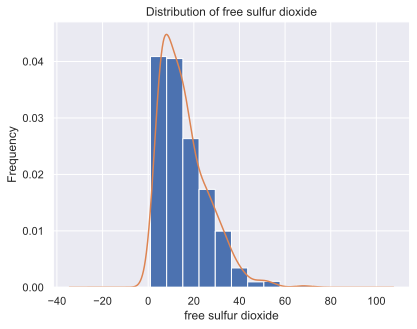

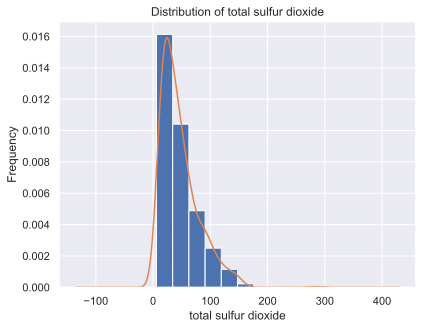

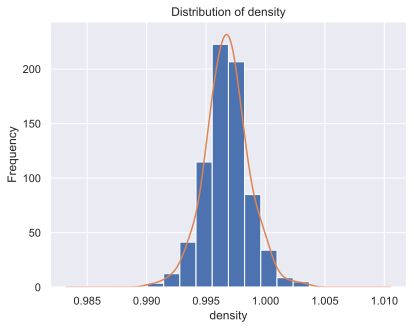

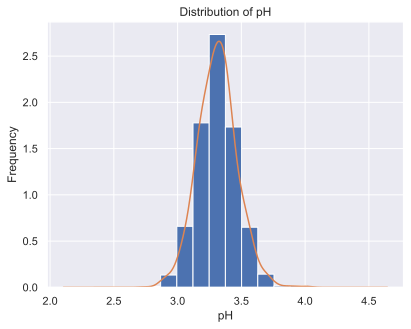

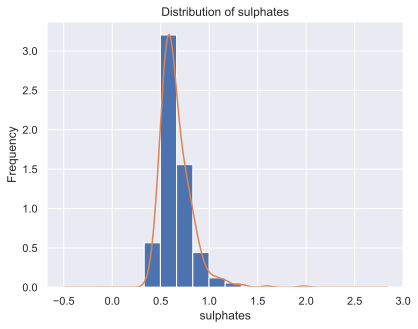

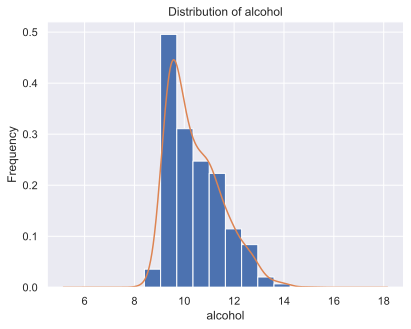

In [4]:
#each feature explore
columns = ['fixed acidity','volatile acidity','citric acid','residual sugar',
                'chlorides','free sulfur dioxide','total sulfur dioxide','density',
                'pH','sulphates','alcohol']

for i in columns:
    data[i].plot(kind='hist', density=True)
    data[i].plot(kind='kde', bw_method=0.3)
    plt.title(f'Distribution of {i}')
    plt.xlabel(f'{i}')
    plt.ylabel('Frequency')
    plt.show()

# C. Preprocess the data

In [5]:
#split, normalize the train-test data
def preprocess(data):
    train, test = train_test_split(data, test_size=0.2,random_state = 21)
    
    x = train.iloc[:,:11]
    y = train.iloc[:,11]
    x_val = test.iloc[:,:11]
    y_val = test.iloc[:,11]
    
    temp = x.astype({'fixed acidity':'float32','volatile acidity':'float32','citric acid':'float32','residual sugar':'float32',
                'chlorides':'float32','free sulfur dioxide':'float32','total sulfur dioxide':'float32','density':'float32',
                'pH':'float32','sulphates':'float32','alcohol':'float32'})
    x = temp.copy()
    
    temp_val = x_val.astype({'fixed acidity':'float32','volatile acidity':'float32','citric acid':'float32','residual sugar':'float32',
                'chlorides':'float32','free sulfur dioxide':'float32','total sulfur dioxide':'float32','density':'float32',
                'pH':'float32','sulphates':'float32','alcohol':'float32'})
    x_val = temp_val.copy()
    
    scaler = StandardScaler()
    scaler.fit(x)
    x = scaler.transform(x)
    x_val = scaler.transform(x_val)
    
    y = y.values
    y = y.reshape(-1,1)
    y_val = y_val.values
    y_val = y_val.reshape(-1,1)
    y_unnormed = y_val.copy()

    scaler = StandardScaler()
    scaler.fit(y)
    y = scaler.transform(y)
    y_val = scaler.transform(y_val)
    
    return x,y,x_val,y_val,y_unnormed

x,y,x_val,y_val,y_unnormed = preprocess(data)

# D. MCMC creation
### d1. Create a linear regression logic
we will use linear regression as our solution to this problem. Here we set up the function with eager mode disabled, and we will switch the input and output of the function into x,y respectively

In [6]:
D = x.shape[1]
N = x.shape[0]
noise_std_true = 1.0
#define y ~ N(coeffs * x + bias , noise)
def linear_regression(features):
    D = features.shape[1]  
    # coefficients: (D,1)
    coeffs = ed.Normal(loc=tf.zeros([D,1]),scale=tf.ones([D,1]),name="coeffs")
    #bias: (1)
    bias = ed.Normal(loc=tf.zeros([1]), scale=tf.ones([1]),name="bias") 
    #noise: (1)
    noise_std = ed.HalfNormal(scale=tf.ones([1]),name="noise_std")
    # prediction: y ~ N(coeffs * x + bias , noise)
    predictions = ed.Normal(loc=tf.matmul(features, coeffs)+bias,scale=noise_std,name="predictions")
    return predictions

### d2. Create the function to calculate log posterior
recall from the paper, we want to know the posterior of our problem, but due to the intractability of the margincal likelihood, we only know it up to a normalizing constant.
$$
  p(x) = \frac{f(x)}{NC}
$$

but luckily, we can calculate the numerator -- joint probability between likelihood of dataset given parameter and the prior of the parameters.

$$
  posterior = \frac{likelihood * prior}{evidence}
$$

to reach the stationary distribution or posterior in our case, MCMC can use the join probability to help guide us into a correct direction at each step, because joint probability is proportional to the posterior, and increasing one of them is guranteed in increasing the other one. 

So to Implement this, there is a lot of math going on, we will use Edward2 package to define the likelihood * prior, which is the joint probability for us.

In [7]:
#create log joint probability function 
log_joint = ed.make_log_joint_fn(linear_regression)
def target_log_prob_fn(coeffs, bias, noise_std):
    return log_joint(
        features=x, 
        coeffs=coeffs, bias=bias, noise_std=noise_std, 
        predictions=y
    )

### d3. create the MCMC chain
here we will have our parameters (coeffs, bias, noise) in each state of the chain, initialize them as 0s or 1s, and we will use HMC as the method for proposal of the new candidates for our parameters and NUTS sampler as the plug in as described in the paper. 

In [8]:
#number of total iterations
num_results = int(10e3) 
#number of burn-in steps
n_burnin = int(5e3)
#stepsize for leapfrog method
step_size = 0.01
# Parameter sizes
coeffs_size = [D,1]
bias_size = [1]
noise_std_size = [1]

#define the NUTS sampler as kernel
kernel = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=target_log_prob_fn,
    step_size=step_size)

#create the sample chain
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=n_burnin,
    kernel=kernel,
    current_state=[
        tf.zeros(coeffs_size, name='init_coeffs'),
        tf.zeros(bias_size, name='init_bias'),
        tf.ones(noise_std_size, name='init_noise_std'),
    ])
coeffs, bias, noise_std = states

# E. run the MCMC Chain

In [9]:
class Timer:
    def __enter__(self):
        self.t0 = time.time()
    def __exit__(self, *args):
        print('Elapsed time: %0.2fs' % (time.time()-self.t0))
        
#run the chain
with Timer(), tf.Session() as sess:
  [
      coeffs_,
      bias_,
      noise_std_,
      is_accepted_,
  ] = sess.run([
      coeffs,
      bias,
      noise_std,
      kernel_results.is_accepted,
  ])

# Samples after burn-in
coeffs_samples = coeffs_[n_burnin:,:,0]
bias_samples = bias_[n_burnin:]
noise_std_samples = noise_std_[n_burnin:]
accepted_samples = is_accepted_[n_burnin:]

Elapsed time: 74.24s


# F. Analysis the model
### f1. Trace plot
we have 11 features and we will do linear regression on each one of them, so we will have 11 weights distribution, 1 bias distribution and 1 noise distribution as posterior.

In [10]:
#define a plot for chain distribution for parameters
def chain_plot(data, title='', ax=None):
    if ax is None:
        ax = plt.gca()
        ax.plot(data)
        ax.title.set_text(title+" chain")

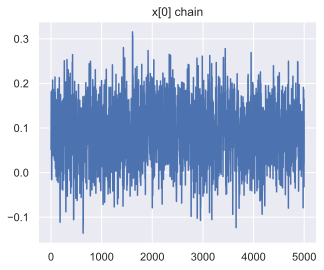

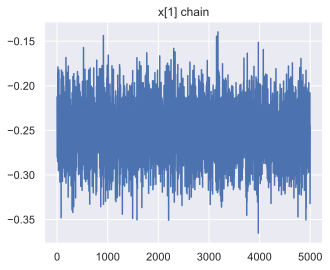

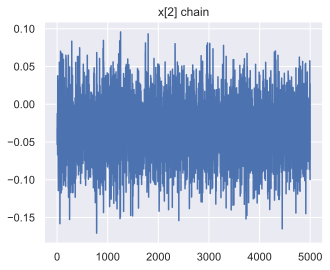

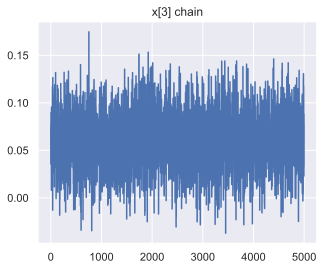

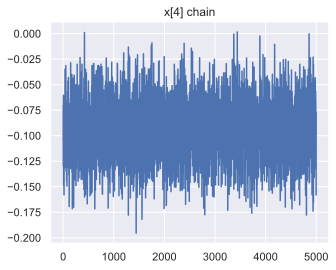

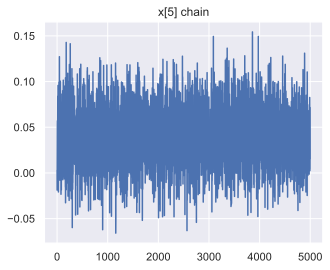

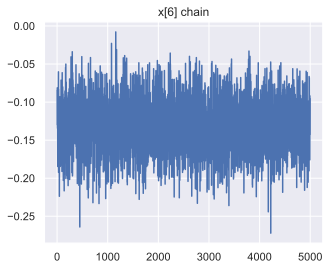

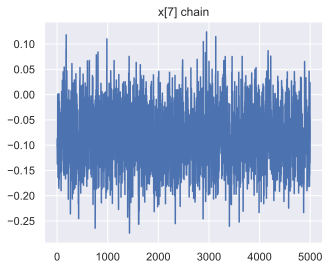

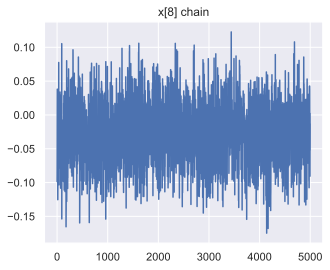

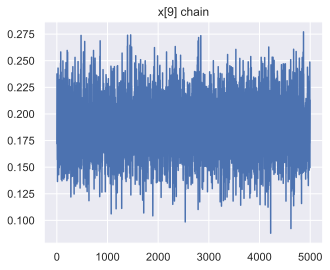

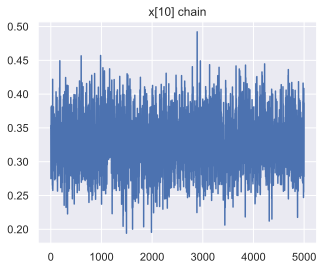

In [11]:
# Plot chains for coefficients
for i in range(D):
    fig = plt.subplots(figsize=(5,4))
    chain_plot(coeffs_samples[:,i], title="x[{}]".format(i))
    plt.show()

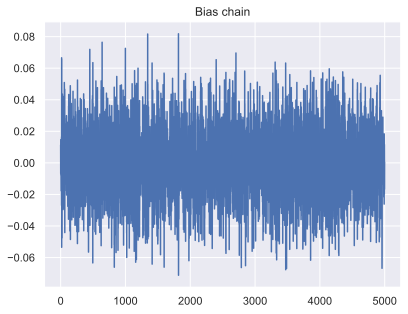

In [12]:
# Plot chains for Bias
chain_plot(bias_samples[:,0],title="Bias")
plt.show()

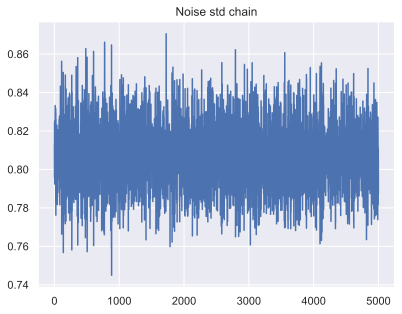

In [13]:
# Plot chains for noise std dev
chain_plot(noise_std_samples[:,0],title="Noise std")
plt.show()

### f2. Density Plot

In [14]:
 #Plot the posterior distribution given MCMC samples'''
def post_plot(data, title='', ax=None, true=None, prc=95):
    if ax is None:
        ax = plt.gca()
        sns.kdeplot(data, ax=ax, shade=True)
        tprc = (100-prc)/2
        ax.axvline(x=np.percentile(data, tprc), linestyle='--')
        ax.axvline(x=np.percentile(data, 100-tprc), linestyle='--')
        ax.title.set_text(title+" distribution")
        if true is not None:
            ax.axvline(x=true)

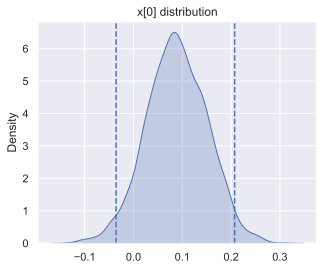

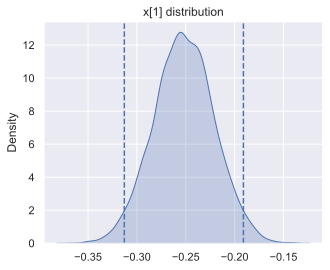

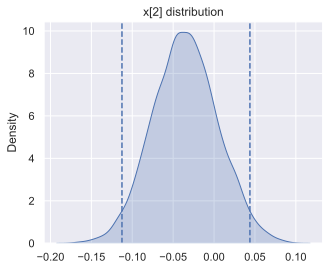

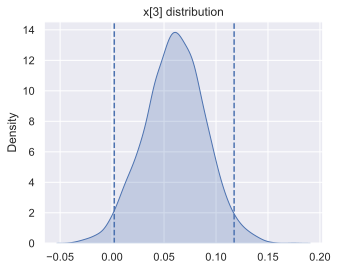

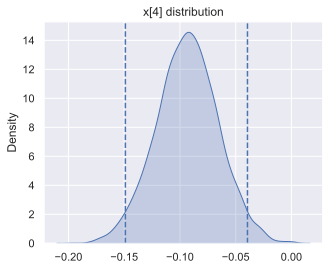

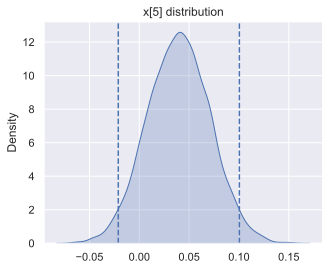

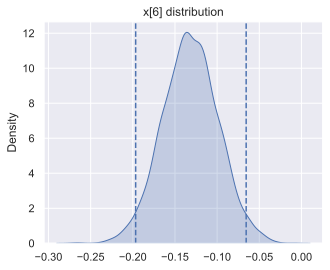

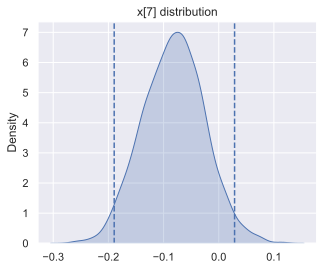

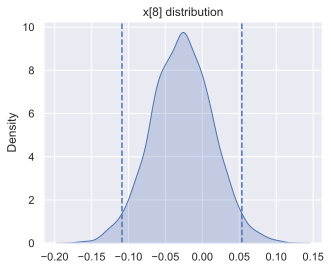

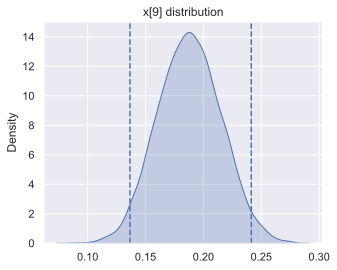

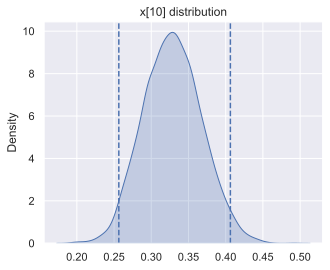

In [15]:
#desity function for weight distribution
for i in range(D):
    fig = plt.subplots(figsize = (5,4))
    post_plot(coeffs_samples[:,i],
                  title="x[{}]".format(i))
plt.show()

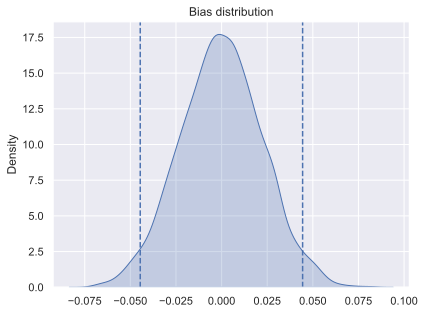

In [16]:
# Plot density for bias
post_plot(bias_samples[:,0],title="Bias")
plt.show()

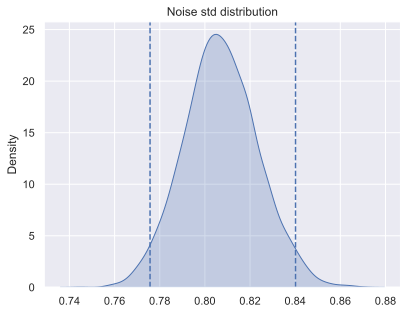

In [17]:
# Plot distribution for noise std dev
post_plot(noise_std_samples[:,0],title="Noise std")
plt.show()

### f3. posterior predictive checks

In [18]:
#check for acceptance rate
print('Acceptance rate: %0.1f%%' % (100*np.mean(accepted_samples)))

Acceptance rate: 100.0%


for this part, we will randomly draw several records. to get the prediction distribution of the records, each x will mapping into y with all 5000 sets of parameters and generate 5000 ys, which will be our distribution.

what's more convient is, in this way, we can also see probability of a certain y, p(y). the intersection of the actually y label with the interpolate curve will be the PDF of this y. This maybe wrong

Text(0.5, 0, 'y')

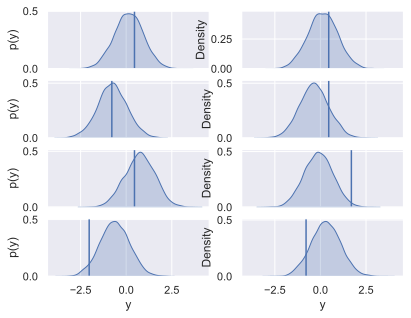

In [19]:
def ind_pred_dist(X):
    '''Compute the prediction distribution'''
    predictions = (np.matmul(X, coeffs_samples.transpose()) + 
                 bias_samples[:,0])
    noise = (noise_std_samples[:,0] * 
           np.random.randn(noise_std_samples.shape[0]))
    return predictions + noise

# Compute prediction distribution for all validation samples
N_val = y_val.shape[0]
Nmcmc = coeffs_samples.shape[0]
prediction_distribution = np.zeros((N_val, Nmcmc))
for i in range(N_val):
    prediction_distribution[i,:] = ind_pred_dist(x_val[i,:])

# Plot random datapoints and their prediction intervals
fig, axes = plt.subplots(4, 2, sharex='all')
for i in range(4):
    for j in range(2):
        ix = i*2+j
        pred_dist = prediction_distribution[ix,:]
        sns.kdeplot(pred_dist, fill=True, ax=axes[i][j])
        axes[i][j].axvline(x=y_val[ix,0])
    axes[i][0].set_ylabel('p(y)')

axes[3][0].set_xlabel('y')
axes[3][1].set_xlabel('y')

we we can also get is the probability of the actual label base on our distribution generated from the given record and the paramters distribution

Probability of wine quality as 6 is 41.86%


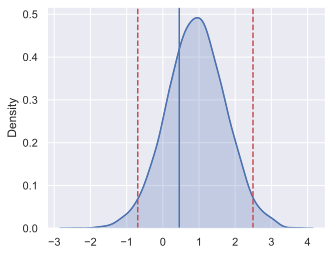

In [20]:
pred_dist = prediction_distribution[100,:]

fig, ax = plt.subplots(figsize=(5, 4))
sns.kdeplot(pred_dist, fill=True)

density, x = sns.kdeplot(pred_dist, fill=False).get_lines()[0].get_data()
f = interp1d(density, x)
y = f(y_val[100,0])
print('Probability of wine quality as {} is {:0.2f}%'.format(y_unnormed[100,0],y*100))
ax.axvline(x=y_val[100,0])
ax.axvline(np.quantile(pred_dist, 0.025), color='r', linestyle="dashed")
ax.axvline(np.quantile(pred_dist, 0.975), color='r', linestyle="dashed")

plt.show()

The interpolation is affected with the bandwidth and the scale of the data.
Here we can see, the max probability is .... and the actual label or this record is 6 (in our graph, the blue vertical line indicating the actual label, it's pointing in between 0 and 1 because the normalizing), and base on the interpolation of our density curve, we can get that for this record, the probability of we will predict the quality of it as 6 is around 42%

### f4. model performance plots

even though accuracy is not where BNN shines, but we can still trace it to see if we are underfitting or overfitting.
see if we can add a graph that looks like this
https://nbviewer.org/github/krasserm/bayesian-machine-learning/blob/master/bayesian_neural_networks.ipynb#Appendix

what we can also get is a residual distribution, between the actual label and the mean of each prediction distribution, the gap should also give us a distribution

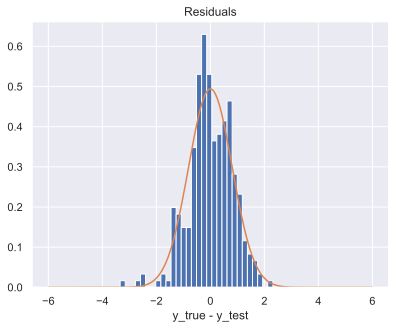

In [21]:
# Plot the residual distribution
plt.figure()
y_pred = np.mean(prediction_distribution, axis=1)
residuals = y_val[:,0]-y_pred
plt.hist(residuals, bins=30, density=True)
xx = np.linspace(-6, 6, 200)
plt.plot(xx, norm.pdf(xx, scale=np.std(residuals)))
plt.title('Residuals')
plt.xlabel('y_true - y_test')
plt.show() 